In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/entity-annotated-corpus/ner_dataset.csv
/kaggle/input/entity-annotated-corpus/ner.csv


In [2]:
data = pd.read_csv('/kaggle/input/entity-annotated-corpus/ner_dataset.csv', encoding = 'latin1')

In [3]:
data = data.fillna(method = 'ffill')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


find no of unique words from datasets

In [4]:
print("no of unique words in datasers: ", data['Word'].nunique())

no of unique words in datasers:  35178


In [5]:
print("no of unique tags in datasets, ", data['Tag'].nunique())

no of unique tags in datasets,  17


In [6]:
words = list(set(data['Word'].values))

In [7]:
words.append('ENDPAD')
num_words = len(words)

In [8]:
tags = list(set(data['Tag'].values))
num_tags = len(tags)

In [9]:
num_tags

17

# Retrive the sentences and Corrosponding tags

In [10]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        agg_func = lambda s: [(w,p,t) for w,p,t in zip(s['Word'].values.tolist(),
                                                      s['POS'].values.tolist(), 
                                                      s['Tag'].values.tolist())]
        self.grouped = self.data.groupby('Sentence #').apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [11]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [12]:
sentences[1]

[('Iranian', 'JJ', 'B-gpe'),
 ('officials', 'NNS', 'O'),
 ('say', 'VBP', 'O'),
 ('they', 'PRP', 'O'),
 ('expect', 'VBP', 'O'),
 ('to', 'TO', 'O'),
 ('get', 'VB', 'O'),
 ('access', 'NN', 'O'),
 ('to', 'TO', 'O'),
 ('sealed', 'JJ', 'O'),
 ('sensitive', 'JJ', 'O'),
 ('parts', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('the', 'DT', 'O'),
 ('plant', 'NN', 'O'),
 ('Wednesday', 'NNP', 'B-tim'),
 (',', ',', 'O'),
 ('after', 'IN', 'O'),
 ('an', 'DT', 'O'),
 ('IAEA', 'NNP', 'B-org'),
 ('surveillance', 'NN', 'O'),
 ('system', 'NN', 'O'),
 ('begins', 'VBZ', 'O'),
 ('functioning', 'VBG', 'O'),
 ('.', '.', 'O')]

# Mapping between sentence and tag

In [13]:
word2idx = {w : i+1 for i,w in enumerate(words)}

In [14]:
word2idx

{'Adil': 1,
 'ISSUED': 2,
 'Majid': 3,
 'Vaile': 4,
 'entertainment': 5,
 'baggage': 6,
 'wrongdoing': 7,
 'Morgenthau': 8,
 'Imphal': 9,
 'taping': 10,
 'conferring': 11,
 'tariffs': 12,
 'hopefuls': 13,
 'videotape': 14,
 'nickel': 15,
 'tsunami-affected': 16,
 'Lions': 17,
 'contact': 18,
 '53-year-old': 19,
 'deactivate': 20,
 'funneled': 21,
 'broad': 22,
 'Vanhanen': 23,
 'performed': 24,
 'reforestation': 25,
 'rest': 26,
 'declaring': 27,
 'whistleblower': 28,
 'Dimona': 29,
 'al-Ghurabaa': 30,
 'Transit': 31,
 'Sugarcane': 32,
 'HARES': 33,
 'abrupt': 34,
 'Vladislav': 35,
 'Libyan-owned': 36,
 'Winds': 37,
 'Mourino': 38,
 'defaulting': 39,
 'fees': 40,
 'greenback': 41,
 'Tamin': 42,
 'Tiechui': 43,
 'meadow': 44,
 'decommission': 45,
 'Milan': 46,
 'minds': 47,
 'LCI': 48,
 'Olo': 49,
 'compensatiion': 50,
 'photographed': 51,
 'Pollsters': 52,
 'Shakespeareans': 53,
 'quite': 54,
 'visas': 55,
 'Tzachi': 56,
 'Duchess': 57,
 'Domenici': 58,
 'Camilla': 59,
 'available': 60

In [15]:
tag2idx = {t : i for i,t in enumerate(tags)}

In [16]:
tag2idx

{'B-gpe': 0,
 'I-tim': 1,
 'B-geo': 2,
 'I-art': 3,
 'B-tim': 4,
 'I-gpe': 5,
 'I-eve': 6,
 'I-nat': 7,
 'B-eve': 8,
 'I-org': 9,
 'B-org': 10,
 'I-geo': 11,
 'B-nat': 12,
 'O': 13,
 'B-art': 14,
 'I-per': 15,
 'B-per': 16}

# Padding input sentence and train test split

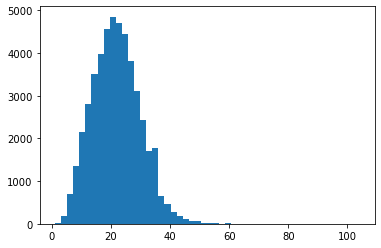

In [17]:
import matplotlib.pyplot as plt
plt.hist([len(s) for s in sentences], bins = 50)
plt.show()

In [18]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50 

x = [[word2idx[w[0]] for w in s] for s in sentences]
x = pad_sequences(x, maxlen = max_len, padding = 'post', value = num_words-1)

In [19]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(y, maxlen = max_len, padding = 'post', value = tag2idx["O"])
y = [to_categorical(i, num_classes = num_tags) for i in y]

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = 0.1, random_state = 1)

# build and compile bidirectional model

In [21]:
from tensorflow.keras import Model,Input
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [22]:
input_word = Input(shape=(max_len, ))
model = Embedding(input_dim = num_words, output_dim = max_len, input_length = max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units = 100, return_sequences =True, recurrent_dropout = 0.1))(model)
out = TimeDistributed(Dense(num_tags, activation = 'softmax'))(model)
model = Model(input_word, out)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# train the model

In [24]:
!pip install git+git://github.com/stared/livelossplot.git

  Cloning git://github.com/stared/livelossplot.git to /tmp/pip-req-build-_yqauzri
ERROR: Command errored out with exit status 128: git clone -q git://github.com/stared/livelossplot.git /tmp/pip-req-build-_yqauzri Check the logs for full command output.


In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [26]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 1, verbose = 0, mode = 'max', restore_best_weights = False )
history = model.fit(X_train, np.array(y_train),
          epochs=3,
          validation_split = 0.2,
          batch_size = 32,  
          verbose=1)

Epoch 1/3
1080/1080 [==============================] - 120s 111ms/step - loss: 0.1882 - accuracy: 0.9573 - val_loss: 0.0660 - val_accuracy: 0.9808
Epoch 2/3
1080/1080 [==============================] - 118s 109ms/step - loss: 0.0526 - accuracy: 0.9846 - val_loss: 0.0501 - val_accuracy: 0.9847
Epoch 3/3
1080/1080 [==============================] - 119s 110ms/step - loss: 0.0381 - accuracy: 0.9884 - val_loss: 0.0485 - val_accuracy: 0.9851


In [27]:
model.evaluate(X_test,np.array(y_test))

150/150 [==============================] - 2s 16ms/step - loss: 0.0495 - accuracy: 0.9852


[0.04951782152056694, 0.9852001667022705]

In [29]:
i = np.random.randint(0, X_test.shape[0])
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p,axis = -1)

In [31]:
y_true = np.argmax(np.array(y_test), axis = -1)[i]
print("{:15}{:5}\t {}\n".format("Word","True","Y_predict"))
print("*"*40)
for w,true,pred in zip(X_test[i],y_true,p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred] ))

Word           True 	 Y_predict

****************************************
